# Predicting Time Series ? Predicting Future

# What Is Time Series?

* Variable — anything that changes over time
* Time periods — Can be daily, weekly, monthly, yearly etc
* Variable Behaviour — Quantifiable value

## Past Is Important
**Most time series data is dependent on its past values. Recent past values are good indicators of a variable’s behaviour.**

#### Now let’s consider the effect of Friday’s price on Sunday’s price
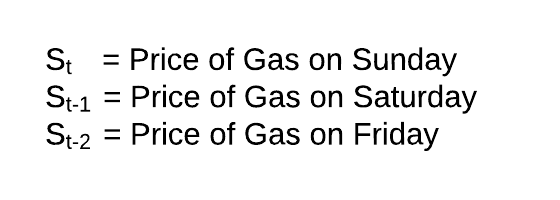

## Past data can be a good indicator of future data

# The Difference Between ARIMA and SARIMA Models

* SARIMA model has 7 parameters. 
* The first 3 parameters are the same as an ARIMA model.
* The last 4 define the seasonal process.
* It takes the seasonal autoregressive component, the seasonal difference, the seasonal moving average component, the length of the season, as additional parameters
* SARIMA(1,1,1)(0,0,0,X) where X can be any whole number.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
data = pd.read_csv('/kaggle/input/time-series-starter-dataset/Month_Value_1.csv')
data.head()
data.dropna(inplace=True)
data['Period'] = pd.to_datetime(data['Period'],format='%d.%m.%Y')

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(15,5)})
import seaborn as sns

# plt.figure(figsize=(15,5))
# sns.distplot(data['Sales_quantity'])
plt.plot(data.Sales_quantity)


In [ ]:
data.index = data.Period
# Log Transformation
data['log'] = np.log(data.Sales_quantity)

In [ ]:
import statsmodels.tsa.api as smt

fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(data['Sales_quantity'], lags=12, ax=axes[0])
smt.graphics.plot_pacf(data['Sales_quantity'], lags=12, ax=axes[1])
plt.tight_layout()

In [ ]:
import itertools
import warnings
warnings.filterwarnings('ignore')

# Parameters - p, d, q, P, D, Q
### Let's try all possible parameters and choose the best set of parameters that gives less AIC score.

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
pdq

In [ ]:
seasonal_pdq

In [ ]:
import statsmodels.api as sm
# import statsmodels.tsa.api as smt
# import statsmodels.formula.api as smf

best_aic = np.inf

best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(data['Sales_quantity'],
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = temp_model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            print('he')

print("Best SARIMAX {} x {} 12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

# Using AIC to Test ARIMA Models
## The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic.


## When comparing two models, the one with the lower AIC is generally “better”. 

In [ ]:
best_pdq = (0, 1, 1)
best_seasonal_pdq = (0, 1, 1, 12)

In [ ]:
best_model = sm.tsa.statespace.SARIMAX(data['Sales_quantity'],
                                      order=best_pdq,
                                      seasonal_order=best_seasonal_pdq,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

In [ ]:
best_results.summary()

In [ ]:
best_results.plot_diagnostics(figsize=(14,10))

In [ ]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2015-02-01'))
pred_dynamic_ci = pred_dynamic.conf_int()

# conf_int = confidence Interval


In [ ]:
pred_dynamic.summary_frame()

In [ ]:
pred_dynamic_ci

In [ ]:
result_predicted = pred_dynamic.predicted_mean
result_truth = data['Sales_quantity'].iloc[1:]

In [ ]:
plt.plot(result_truth, label='original')
plt.plot(result_predicted, label='fitted Values')
# plt.plot(rng['future'], label='Future Values')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((result_predicted-result_truth)**2)/len(result_truth)))


In [ ]:
y = best_results.get_forecast(steps=10)

In [ ]:
y.summary_frame()

In [ ]:
x = best_results.forecast(steps=10)

In [ ]:
x

In [ ]:
plt.plot(result_truth, label='original')
plt.plot(result_predicted, label='fitted Values')
plt.plot(x, label='Future Values')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((result_predicted-result_truth)**2)/len(result_truth)))
